In [11]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from dataset import Dataset
from PINN import PINN, get_loss, train
from scipy.integrate import odeint, solve_ivp

PATH = 'data/correct_data.xlsx'

def get_data(exp: str = 'BR01'):
    xls = pd.ExcelFile(PATH)
    df = xls.parse(exp)
    df.columns = ['Time', 'Biomass', 'Glucose']
    print(f'Dataset shape: {df.shape}')
    t_train = df['Time'].values
    u_train = df[['Biomass', 'Glucose']].values
    return df,t_train, u_train

In [12]:
df, t_train, u_train = get_data(exp='BR01')
pinn = PINN(1, 2, T_START=df['Time'].min(), T_END=df['Time'].max())
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
criterion = nn.MSELoss()

Dataset shape: (9, 3)


In [13]:
# Train data to tensor
ts_train = torch.tensor(t_train, requires_grad=True).float().view(-1,1)
us_train = torch.tensor(u_train, requires_grad=True).float().view(-1,2)

In [14]:
LOSS = train(pinn, 10000, ts_train=ts_train, us_train=us_train, optimizer=optimizer, criterion=criterion)

Epoch: 0, Loss: 21.167261123657227, ODE Loss: 0.005754849873483181
mu_max: 0.49900001287460327, Km: 0.5009999871253967, Y_XS: 0.5009999871253967


Epoch: 500, Loss: 0.13477325439453125, ODE Loss: 0.044943585991859436
mu_max: 0.5998502373695374, Km: 0.7473110556602478, Y_XS: 0.34127315878868103
Epoch: 1000, Loss: 0.03491866588592529, ODE Loss: 0.015538354404270649
mu_max: 0.7774620652198792, Km: 0.4526498019695282, Y_XS: 0.40828078985214233
Epoch: 1500, Loss: 0.014128092676401138, ODE Loss: 0.0077526019886136055
mu_max: 0.8183550238609314, Km: 0.13364200294017792, Y_XS: 0.4519195556640625
Epoch: 2000, Loss: 0.0065567027777433395, ODE Loss: 0.0022580414079129696
mu_max: 0.7943280935287476, Km: 0.014773698523640633, Y_XS: 0.4467107355594635
Epoch: 2500, Loss: 0.24173901975154877, ODE Loss: 0.047505687922239304
mu_max: 0.6413825750350952, Km: 0.03430012986063957, Y_XS: 0.585981011390686
Epoch: 3000, Loss: 0.018862292170524597, ODE Loss: 0.008770238608121872
mu_max: 0.7423563599586487, Km: 0.039394136518239975, Y_XS: 0.4437406361103058
Epoch: 3500, Loss: 0.010023227892816067, ODE Loss: 0.004977366887032986
mu_max: 0.7831639051437378, 

In [21]:
print(f'mu_max: {pinn.mu_max.item()}')
print(f'Ks: {pinn.Km.item()}')
print(f'Yxs: {pinn.Y_XS.item()}')


mu_max: 0.8029059767723083
Ks: 0.00015362421981990337
Yxs: 0.4459298253059387


In [24]:
y0 = [u_train[0,0], u_train[0,1]]
y0[0]

0.01

mu_max: 0.8029059767723083, Km: 0.00015362421981990337, Y_XS: 0.4459298253059387


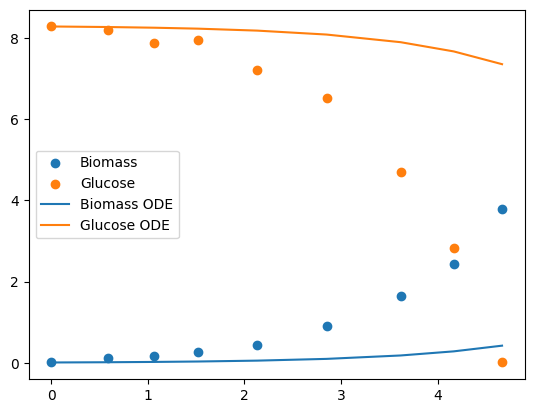

In [36]:
from scipy.integrate import odeint, solve_ivp

def ode_func(y, t, mu_max, Km, Y_XS):
    X = y[0]
    S = y[1]
    
    mu = mu_max*S/(Km + S)
    
    dXdt = mu*X
    dSdt = -1/Y_XS * mu * X
    
    return [dXdt, dSdt]

# solve ODE
mu_max = pinn.mu_max.item()
Km = pinn.Km.item()
Y_XS = pinn.Y_XS.item()
print(f'mu_max: {mu_max}, Km: {Km}, Y_XS: {Y_XS}')

y0 = [u_train[0,0], u_train[0,1]]

sol = odeint(ode_func, y0, t_train, args=(mu_max, Km, Y_XS))

# Plot
plt.figure()
plt.scatter(t_train, u_train[:,0], label='Biomass')
plt.scatter(t_train, u_train[:,1], label='Glucose')
plt.plot(t_train, sol[:,0], label='Biomass ODE')
plt.plot(t_train, sol[:,1], label='Glucose ODE')
plt.legend()
plt.show()